In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import scale
from statsmodels.api import OLS

from donatello.components.data import Dataset
from donatello.components import transformers

In [2]:
prices = pd.read_csv('data/single_family_home_values.csv')
prices['last_sale_date'] = pd.to_datetime(prices['last_sale_date'])
prices.head()

,address,city,state,zipcode,property_type,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,last_sale_date,estimated_value
0,2495 S Milwaukee St,Denver,CO,80210,Single Family Residence,3885,7500.0,13,4,5.0,2010,350000,2010-06-07,1684147
1,2690 Niagara St,Denver,CO,80207,Single Family Residence,1343,7500.0,6,3,1.0,1948,31500,1978-02-01,343104
2,3425 Grove St,Denver,CO,80211,Single Family Residence,992,6250.0,5,2,2.0,1921,258000,2002-02-19,510436
3,4794 Claude Ct,Denver,CO,80216,Single Family Residence,491,2990.0,3,1,1.0,1891,0,2011-04-27,184105
4,3640 N Gaylord St,Denver,CO,80205,Single Family Residence,1365,4690.0,6,3,1.0,1912,52600,1980-09-01,390055


In [3]:
cpi = pd.read_csv('data/denver_cpi.csv')
cpi['DATE'] = pd.to_datetime(cpi['DATE'])
cpi.head()

,DATE,CUUSA433SAH
0,1984-01-01,104.1
1,1985-01-01,106.8
2,1986-01-01,108.2
3,1987-01-01,109.6
4,1988-01-01,110.0


In [4]:
df = pd.merge_asof(prices.sort_values(by='last_sale_date'), cpi, 
                   left_on='last_sale_date', right_on='DATE', direction='nearest')
df.head()

,address,city,state,zipcode,property_type,square_footage,lot_size,num_rooms,num_bedrooms,num_baths,year_built,last_sale_amount,last_sale_date,estimated_value,DATE,CUUSA433SAH
0,3564 Kearney St,Denver,CO,80207,Single Family Residence,1008,6410.0,6,3,1.0,1954,50600,1966-04-14,340952,1984-01-01,104.1
1,1585 S Meade St,Denver,CO,80219,Single Family Residence,947,6010.0,5,3,1.0,1952,21500,1975-02-01,257016,1984-01-01,104.1
2,63 Yates St,Denver,CO,80219,Single Family Residence,803,6250.0,4,2,1.0,1955,25000,1975-03-01,241671,1984-01-01,104.1
3,3020 Newton St,Denver,CO,80211,Single Family Residence,2000,6350.0,9,4,3.0,1909,15000,1975-03-01,762124,1984-01-01,104.1
4,2481 S Holly Pl,Denver,CO,80222,Single Family Residence,2398,13024.0,0,4,3.0,1957,45000,1975-03-01,554375,1984-01-01,104.1


In [5]:
d = Dataset(raw=df, target='estimated_value')

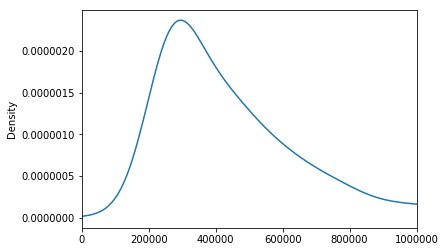

In [6]:
d.targetTrain.plot(kind='kde', xlim=(0,1000000))
plt.show()

In [7]:
def build_mask(dataset, columns, threshold):
    X = scale(dataset.designData[columns])
    y = dataset.targetData.values
    model = OLS(y, X)
    mask = pd.np.abs((model.fit().outlier_test()[:, 0]) < threshold)
    return mask

def transform(dataset, columns=('square_footage',), threshold=2):
    columns = list(columns) if columns else list(dataset.designData)
    mask = build_mask(dataset, columns, threshold)
    print(len(dataset))
    X = dataset.designData.loc[mask]
    y = dataset.targetData.loc[mask]
    print(len(X))
    return X, y

def plot():
    mask = build_mask(d.subset('train'), ['square_footage'], 2)
    plt.figure(figsize=(20,10))
    plt.xlim(0, d.designTrain['square_footage'].max() * 1.01) 
    plt.ylim(0, d.targetTrain.max() * 1.01) 
    plt.plot(d.designTrain.loc[mask, 'square_footage'].values, d.targetData.loc[mask].values, 'b.', alpha=.1)
    plt.plot(d.designData.loc[~mask, 'square_footage'].values, d.targetData.loc[~mask].values, 'r*', alpha=.75)
    plt.legend('inliers', 'outliers')
    plt.xlabel('square footage')
    plt.ylabel('price in current USD')
    plt.show()

In [8]:
outlier_removal = transformers.AccessTransformer(datasetDap={'cb': transform})

In [9]:
from donatello.utils.helpers import access

In [10]:
d_t = access(d, cb=transform)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


3417
3353


In [11]:
d_t = outlier_removal.fit_transform(dataset=d.subset('train'))

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


2733
2680


ValueError: DataFrame constructor not properly called!

In [ ]:
len(d), len(d.subset('train')), len(d_t), len(d_t.designData)